### 프로젝트 : 모든 장르 간 편향성 측정해 보기

In [18]:
import os
import konlpy
import gensim
import sklearn
import seaborn as sns
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt

### STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [14]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b


In [15]:
def weat_score(X, Y, A, B):
    
    # 분석하고자 하는 단어 X가 단어 집합 A,B 각각에서 어떤 관계를 가지고 있눈자
    s_X = s(X, A, B) # 양수인 경우 X는 A에 더 유사함
    s_Y = s(Y, A, B) # 음수인 경우 Y는 B에 더 유사함

    # 유사도 평균
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    # 두 가지 평균을 합쳐서 표준 편차를 구한다
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    # weat score을 구한다. 
    # A에 가까운 X의 유사도 평균과 B -가까운 Y의 유사도 평균
    # X art  Y gen 
    return  (mean_X-mean_Y)/std_dev


### genre.txt & name List

In [58]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [59]:
# 예술 영와 일반 영화
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

### Konlpy를 사용하여 토큰화

### 파일 읽어오기

In [70]:
# 명사에 대해서만 추출
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            # 명사만 추출하는 과정인 것 같음
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [71]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [72]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [73]:
print(art[:11])

사운드 엔지니어 상우


In [63]:
#  txt 파일을 읽어 품사가 명사인 경우 tokenized 변수명으로 저장
# konlpy mecab사용
from konlpy.tag import Okt

okt = Okt()
tokenized = []

# list 내에 있는 
for gen in genre_txt:
    with open(os.getenv('HOME')+'/aiffel/weat/' + gen, 'r') as file:
        while True:
            line = file.readline()
            if not line: break
            words = okt.pos(line, stem=True, norm=True)
            res = []
            for w in words:
                if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                    res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
            tokenized.append(res)

In [64]:
print(len(tokenized))

68856


### STEP 2. 추출된 결과로 embedding model 만들기


In [65]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
# word2Vec 모델에 토큰화 리스트를 넣고 최소 빈도수는 3으로 하고 window size는 5로 한다.
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['사랑'])

[('애정', 0.7110742926597595),
 ('첫사랑', 0.6965159773826599),
 ('만남', 0.6942669749259949),
 ('연애', 0.6930215358734131),
 ('행복', 0.6856056451797485),
 ('관계', 0.6729819178581238),
 ('연인', 0.6717573404312134),
 ('고백', 0.6713302135467529),
 ('키스', 0.6676875352859497),
 ('상처', 0.6673199534416199)]

In [75]:
# 대표하는 단어를 처리해야한다. 
# target data
# TF-IDF 사용
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [77]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [78]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

# w1안에 0번째가 feature 이름
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [79]:
print(w1[:10])

[[3181, 0.3041128528402531], [28249, 0.29468299693822975], [20429, 0.29141881604906783], [25869, 0.26077178436749193], [16220, 0.25460610935463046], [16216, 0.2341143071060028], [23976, 0.15649933929704138], [33358, 0.15142172458056727], [4950, 0.1338314164556391], [230, 0.11243289729335534]]


In [80]:
# 두 개념축이 대조되도록 대표하는 단어 셋을 만들고 싶기 때문에 단어가 서로 중복되지 않게 단어셋을 추출
n = 15
w1_, w2_ = [], []
# 100 에서 150개로 변경 - 중복 제거
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [96]:
import pandas as pd
print(pd.DataFrame(np.array(w1_)).nunique())
print(len(w1_))

0    100
dtype: int64
100


In [87]:
# 예술
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [88]:
# 일반영화
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


### STEP 3. target, attribute 단어 셋 만들기
- 이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 
- 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 
- 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제
-  단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향
- TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식

In [128]:
# TF-IDF 방식으로 벡터화
# genre 집합
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)
print(X)

(21, 42191)
  (0, 13952)	0.0033499152670364227
  (0, 2039)	0.002285577535002845
  (0, 36242)	0.0027154578798064487
  (0, 24831)	0.004586815128045722
  (0, 37721)	0.0021681209719700955
  (0, 7717)	0.00289571176127901
  (0, 7669)	0.0020600714080574456
  (0, 39780)	0.0020600714080574456
  (0, 33059)	0.004586815128045722
  (0, 22451)	0.004039478220209368
  (0, 12262)	0.0025564626882533786
  (0, 30804)	0.00289571176127901
  (0, 2066)	0.0033499152670364227
  (0, 21022)	0.0033499152670364227
  (0, 22525)	0.003103799596089732
  (0, 33036)	0.00289571176127901
  (0, 9187)	0.0054309157596128975
  (0, 17581)	0.003103799596089732
  (0, 33873)	0.0020600714080574456
  (0, 41140)	0.0024142366429167855
  (0, 3176)	0.0016979421447241006
  (0, 1538)	0.001960033137159373
  (0, 11684)	0.004039478220209368
  (0, 34375)	0.00457115507000569
  (0, 7162)	0.0024142366429167855
  :	:
  (20, 26530)	0.01970255467117182
  (20, 28182)	0.0026983499239041867
  (20, 31976)	0.007388458001689434
  (20, 4696)	0.01195366227

In [129]:
m = [X[i].tocoo() for i in range(X.shape[0])]
# m에 sparse matrix type이 들어 있음
print(m[0].col)
print(m[0].data)

[13952  2039 36242 ... 39665 31911 20740]
[0.00334992 0.00228558 0.00271546 ... 0.0061912  0.00412014 0.07154464]


In [130]:
# m[:].col 이 word index가 모두 들어 있고 m.data에 해당 벡터 값이 들어가 있다
print(vectorizer.get_feature_names()[13952])

백업


---

In [131]:
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

# 높은 순으로 정렬
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
    
attributes = []
for i in range(len(w)):
    print("---------------------")
    print(genre_name[i], end=': ')
    attr = [] 
    j = 0
    while (len(attr) < 20):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            # i 장르 j 단어 
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    
    # 이전 attribution에 없으면 단어 추가
    attributes.append(attr)

#장르에 해당하는 키워드
print(w[0][0][0])

---------------------
SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, ---------------------
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, ---------------------
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인, ---------------------
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, ---------------------
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품, ---------------------
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 통해, 그녀, 여성, 가족, 한국, ---------------------
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 가족, 단편, 서울, 대한, 아들, ---------------------
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 사실, ---------------------
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 프롤, 모도, 카르피, 

In [132]:
attributes[0][:5]

['위해', '자신', '지구', '시작', '사람']

In [133]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [134]:
# 분석하고자 하는 대상 X ,Y  데이터 집합 A,B 준비하기
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [135]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.65295476
SF 공연 -0.24082793
SF 공포(호러) -0.5627334
SF 기타 0.31957012
SF 다큐멘터리 0.55422705
SF 드라마 -0.2771139
SF 멜로로맨스 -0.8094673
SF 뮤지컬 0.2881021
SF 미스터리 -0.6172574
SF 범죄 0.03049441
SF 사극 -0.66340905
SF 서부극(웨스턴) -0.4368552
SF 성인물(에로) -0.6859997
SF 스릴러 -0.5426324
SF 애니메이션 0.33747458
SF 액션 -0.08842199
SF 어드벤처 -0.7339485
SF 전쟁 0.33912602
SF 코미디 -0.6411739
SF 판타지 -0.027718803
가족 공연 0.52364445
가족 공포(호러) 0.279576
가족 기타 0.812759
가족 다큐멘터리 0.85917985
가족 드라마 0.65949976
가족 멜로로맨스 -0.59955496
가족 뮤지컬 0.78716415
가족 미스터리 -0.0098103825
가족 범죄 0.64657885
가족 사극 0.3385161
가족 서부극(웨스턴) 0.7752091
가족 성인물(에로) -0.28058398
가족 스릴러 0.08386617
가족 애니메이션 0.8886051
가족 액션 0.651678
가족 어드벤처 0.37181023
가족 전쟁 0.81186557
가족 코미디 0.26550716
가족 판타지 0.6859545
공연 공포(호러) -0.17261265
공연 기타 0.8750928
공연 다큐멘터리 0.8718048
공연 드라마 0.0017771943
공연 멜로로맨스 -0.6876911
공연 뮤지컬 0.9192835
공연 미스터리 -0.30958268
공연 범죄 0.21701683
공연 사극 -0.3622179
공연 서부극(웨스턴) -0.13343906
공연 성인물(에로) -0.62181205
공연 스릴러 -0.26089635
공연 애니메이션 0.9104495
공연 액션 0.16546015
공

In [167]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)
print(pc_A)

[[-3.2749243  -3.806979  ]
 [-3.1976635  -2.14563   ]
 [-1.7297194  -0.7109526 ]
 [-2.328271    1.4126738 ]
 [-0.6993885  -2.848634  ]
 [-1.6764188   1.3164797 ]
 [-3.5517445  -1.1622325 ]
 [ 7.9629173   0.11295117]
 [-1.786453   -3.5334113 ]
 [-1.7082609  -4.045226  ]
 [13.279857   -4.930866  ]
 [-1.5853308   3.6480074 ]
 [ 0.40374386  0.8462921 ]
 [ 1.2405778   7.340365  ]
 [ 2.7402325   7.9489727 ]
 [ 3.4069586   1.0322485 ]
 [-0.0683991  -0.54425174]
 [-1.4629538   1.1056415 ]
 [-3.0372388   2.1683407 ]
 [-2.927514   -3.2037957 ]]


---

In [118]:
# 다른 장르와 단어가 전혀 겹치지 않게 구성하기
attributes_remove = []
prev_attr = []  # Keep track of the previous genre's attributes

for i in range(len(w)):
    print("----------------------------------------")
    print(genre_name[i])
    attr = []
    j = 0
    while len(attr) < 20:
        word_index = w[i][j][0]

        if vectorizer.get_feature_names()[word_index] not in prev_attr:
            if vectorizer.get_feature_names()[word_index] in model.wv:
                prev_attr.append(vectorizer.get_feature_names()[word_index])
                attr.append(vectorizer.get_feature_names()[word_index])
                print(vectorizer.get_feature_names()[word_index], end=', ')
        j += 1

    attributes_remove.append(attr)

# 장르에 해당하는 키워드
print(w[0][0][0])

----------------------------------------
SF
위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, ----------------------------------------
가족
엄마, 아빠, 가족, 영화제, 친구, 아주르, 아버지, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 학교, 소년, 슈이트, 이야기, ----------------------------------------
공연
오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키, ----------------------------------------
공포(호러)
사건, 공포, 죽음, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, 비밀, 정체, 저주, 살해, 여자, 의문, 점점, 사고, 명의, ----------------------------------------
기타
서울, 단편, 뉴미디어, 페스티벌, 대한, 독립, 작품, 통해, 아시아나, 다른, 우리, 연출, 모습, 시간, 이미지, 부산, 기억, 상영작, 지하철, 청소년, ----------------------------------------
다큐멘터리
다큐, 다큐멘터리, 감독, 여성, 한국, 환경, 사회, 노동자, 가장, 기록, 역사, 음악, 미국, 카메라, 동안, 대해, 과정, 도시, 지역, 투쟁, ----------------------------------------
드라마
마음, 남편, 서로, 다시, 관계, 생각, 아내, 사이, 때문, 부문, 어머니, 생활, 결혼, 인생, 간다, 순간, 여행, 현실, 일상, 의도, ----------------------------------------
멜로로맨스
섹스, 부부, 회사, 유혹, 연애, 애인, 새엄마, 불륜, 남자친구,

In [119]:
matrix_r = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [122]:
# 분석하고자 하는 대상 X ,Y  데이터 집합 A,B 준비하기
X_r = np.array([model.wv[word] for word in target_art])
Y_r = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A_r = np.array([model.wv[word] for word in attributes_remove[i]])
        B_r = np.array([model.wv[word] for word in attributes_remove[j]])
        matrix_r[i][j] = weat_score(X_r, Y_r, A_r, B_r)

In [123]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix_r[i][j])

SF 가족 -0.45493266
SF 공연 0.2713294
SF 공포(호러) -0.25330248
SF 기타 0.6901528
SF 다큐멘터리 0.77517074
SF 드라마 -0.7256165
SF 멜로로맨스 -0.80629957
SF 뮤지컬 0.4224877
SF 미스터리 0.21587165
SF 범죄 0.14421341
SF 사극 0.3990978
SF 서부극(웨스턴) -0.030550953
SF 성인물(에로) -0.5365925
SF 스릴러 -0.7281937
SF 애니메이션 0.2699288
SF 액션 0.7472866
SF 어드벤처 -0.49616197
SF 전쟁 0.4626055
SF 코미디 -0.35702303
SF 판타지 -0.21146885
가족 공연 0.5927586
가족 공포(호러) 0.19496565
가족 기타 0.9097294
가족 다큐멘터리 0.86414105
가족 드라마 -0.38844067
가족 멜로로맨스 -0.74731475
가족 뮤지컬 0.7638985
가족 미스터리 0.49903753
가족 범죄 0.46781227
가족 사극 0.6917053
가족 서부극(웨스턴) 0.53754234
가족 성인물(에로) -0.32497188
가족 스릴러 -0.3134926
가족 애니메이션 0.74551713
가족 액션 0.77855
가족 어드벤처 0.12495314
가족 전쟁 0.6999669
가족 코미디 -0.015080294
가족 판타지 0.46524426
공연 공포(호러) -0.31826982
공연 기타 0.56636536
공연 다큐멘터리 0.5505313
공연 드라마 -0.6401636
공연 멜로로맨스 -0.79450154
공연 뮤지컬 0.62419665
공연 미스터리 -0.13525403
공연 범죄 -0.15370683
공연 사극 -0.16972375
공연 서부극(웨스턴) -0.4709323
공연 성인물(에로) -0.66186404
공연 스릴러 -0.52832323
공연 애니메이션 -0.21480757
공연 액션 0.22755659

### STEP 4. WEAT score 계산과 시각화
- Heatmap 형태로 시각화
- 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성

In [166]:
from sklearn.decomposition import PCA

pca_r = PCA(n_components=2)
pc_A_r = pca.fit_transform(A_r)
pc_B_r = pca.fit_transform(B_r)
pc_X_r = pca.fit_transform(X_r)
pc_Y_r = pca.fit_transform(Y_r)
print(pc_A_r)


[[-0.1217843   5.48066   ]
 [ 2.4606352  -0.06615406]
 [-2.5372858  -3.8961527 ]
 [-3.5591307   3.6265929 ]
 [ 0.6205956  -4.2752943 ]
 [-3.4382825   2.2677557 ]
 [ 1.6950055  -2.2448382 ]
 [ 5.1441      2.8714352 ]
 [ 4.1433325   1.1960173 ]
 [-1.2000009  -2.3618019 ]
 [ 1.1746067   0.5082791 ]
 [-0.04850643 -2.949536  ]
 [-2.593093   -0.4914625 ]
 [-3.913047   -1.4979365 ]
 [ 2.39866    -0.8250889 ]
 [ 3.0658357  -0.14085573]
 [-2.8418128   3.1657524 ]
 [-2.1987267   0.29501188]
 [ 1.0641997   0.47569206]
 [ 0.6847024  -1.1380738 ]]


---

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

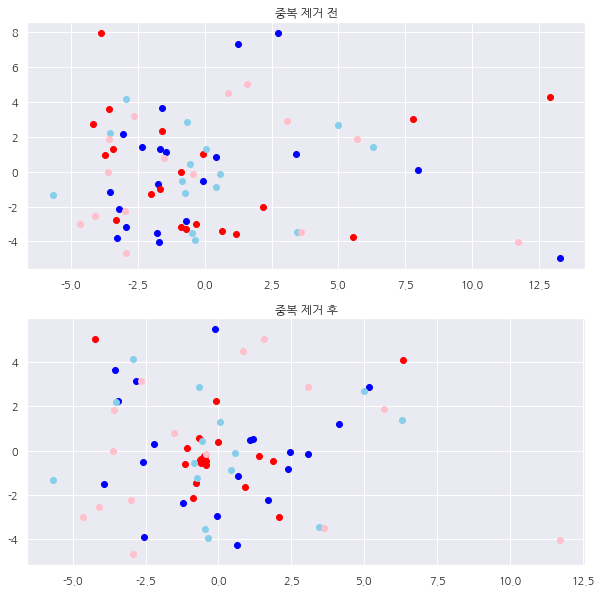

In [165]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].set_title("중복 제거 전")
ax[0].scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax[0].scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax[0].scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax[0].scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

ax[1].set_title("중복 제거 후")
ax[1].scatter(pc_A_r[:,0],pc_A_r[:,1], c='blue', label='A')
ax[1].scatter(pc_B_r[:,0],pc_B_r[:,1], c='red', label='B')
ax[1].scatter(pc_X_r[:,0],pc_X_r[:,1], c='skyblue', label='X')
ax[1].scatter(pc_Y_r[:,0],pc_Y_r[:,1], c='pink', label='Y')

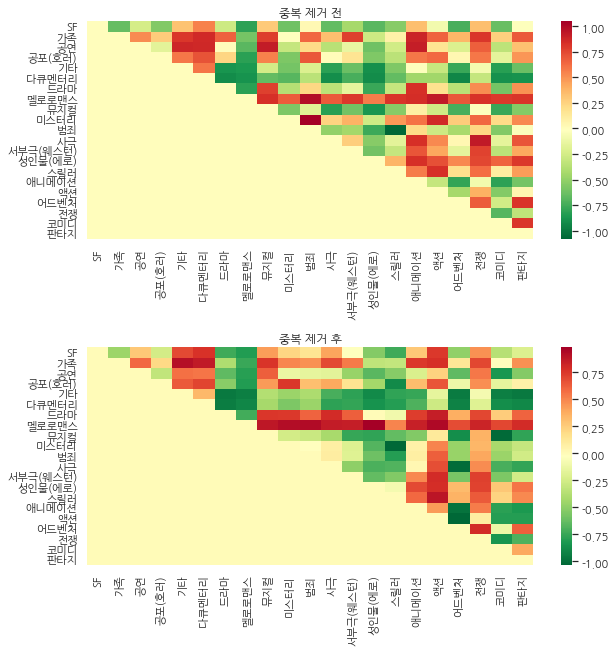

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(2, 1, figsize=(10, 10))

sns.heatmap(matrix, ax=ax1[0], xticklabels=genre_name, yticklabels=genre_name, cmap='RdYlGn_r')
ax1[0].set_title("중복 제거 전")

# 그리드 조절
plt.subplots_adjust(hspace=0.5)

sns.heatmap(matrix_r, ax=ax1[1], xticklabels=genre_name, yticklabels=genre_name, cmap='RdYlGn_r')
ax1[1].set_title("중복 제거 후")
plt.show()


In [191]:
df_list = []
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        df_list.append([genre_name[i], genre_name[j],round(matrix[i][j],3),round(matrix_r[i][j],3) ])
np.array(df_list)

array([['SF', '가족', '-0.653', '-0.455'],
       ['SF', '공연', '-0.241', '0.271'],
       ['SF', '공포(호러)', '-0.563', '-0.253'],
       ['SF', '기타', '0.32', '0.69'],
       ['SF', '다큐멘터리', '0.554', '0.775'],
       ['SF', '드라마', '-0.277', '-0.726'],
       ['SF', '멜로로맨스', '-0.809', '-0.806'],
       ['SF', '뮤지컬', '0.288', '0.422'],
       ['SF', '미스터리', '-0.617', '0.216'],
       ['SF', '범죄', '0.03', '0.144'],
       ['SF', '사극', '-0.663', '0.399'],
       ['SF', '서부극(웨스턴)', '-0.437', '-0.031'],
       ['SF', '성인물(에로)', '-0.686', '-0.537'],
       ['SF', '스릴러', '-0.543', '-0.728'],
       ['SF', '애니메이션', '0.337', '0.27'],
       ['SF', '액션', '-0.088', '0.747'],
       ['SF', '어드벤처', '-0.734', '-0.496'],
       ['SF', '전쟁', '0.339', '0.463'],
       ['SF', '코미디', '-0.641', '-0.357'],
       ['SF', '판타지', '-0.028', '-0.211'],
       ['가족', '공연', '0.524', '0.593'],
       ['가족', '공포(호러)', '0.28', '0.195'],
       ['가족', '기타', '0.813', '0.91'],
       ['가족', '다큐멘터리', '0.859', '0.864'],
      

In [203]:
df = pd.DataFrame(np.array(df_list)).rename(columns={0:'장르',1:'종류',2:'제거 전 weat',3:'제거 후 weat'})
df

,장르,종류,제거 전 weat,제거 후 weat
0,SF,가족,-0.653,-0.455
1,SF,공연,-0.241,0.271
2,SF,공포(호러),-0.563,-0.253
3,SF,기타,0.32,0.69
4,SF,다큐멘터리,0.554,0.775
...,...,...,...,...
205,어드벤처,코미디,-0.258,-0.126
206,어드벤처,판타지,0.822,0.626
207,전쟁,코미디,-0.695,-0.836
208,전쟁,판타지,-0.335,-0.686


- 각 장르의 대표 키워드를 뽑을 때, 장르 별로 공통된 단어(중복된 단어)가 존재했다. 그래서 공통된 단어를 그대로 하는 경우와 완전히 키워드가 서로 독립되도록 구성해서 해보았다. 그랬더니 결과가 비슷한 것도 있고 완전히 반대가 되는 것도 있었다.
- 이 부분에서 다시 느낀 것은 개념 축을 표현하는 단어를 제대로 선정하는 것도 중요할 것이라는 점이다. 결과가 반대로 나오는 것들을 보면 경우에 따라 완전히 잘못 해석하는 오류를 범할 수도 있다.
- 또 개인적으로 생각했던 점은 장르마다 대표 키워드가 중복되어 문제가 될 수도 있지만, 정말로 여러 장르의 대표가 되는 키워드일 수도 있다. 특정 문서와 전체 문서의 빈도를 고려하는 TF-IDF 방식의 경우에는 이러한 부분에서도 한계가 있지 않을까? 하는 생각을 하기도 했다.
- 최근에는 긴 시퀀스를 이해할 수 있는 다른 모델들이 많기 때문에 다른 모델을 사용해서 편향성을 계산해보는 것도 재밌는 실험이 될 수 있을 것 같다